In [33]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys

random.seed(108)

In [34]:
trainPath = 'Train'
trainLabelPath = 'Train/labelXML'
trainImagePath = 'Train/images'

save_file_name = 'Train/labelXML/yololabels.txt'

In [35]:
class Point:
    def __init__(self, x,y):
        self.x = x
        self.y = y

class Points:
    def __init__(self):
        self.points = []
        self.min_x = sys.maxsize
        self.min_y = sys.maxsize
        self.max_x = 0
        self.max_y = 0
    def __len__(self):
        return len(self.points)
    def add_point(self, x,y):
        self.min_x = min(x,self.min_x)
        self.min_y = min(y,self.min_y)
        self.max_x = max(x,self.max_x)
        self.max_y = max(y,self.max_y)
        self.points.append(Point(x,y))
    

class Item:
    def __init__(self, filename, label, points, size):
        self.filename = filename
        self.label = label
        self.points = points
        self.image_size = size

Train/images/10001.tif


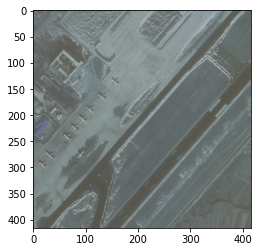

In [36]:
directory = os.fsencode(trainImagePath)

for path in os.listdir(directory):
    x = str(path).replace('b\'','').replace('\'','')
    path = f'Train/images/{x}'
    print(path)
    img = cv2.imread(path, 3)
    
    x_ = img.shape[0]
    y_ = img.shape[1]
    x_scale = 640/x_
    y_scale = 640/y_
    
    img = cv2.resize(img,(416,416));
    
    plt.imshow(img)
    break

In [37]:
directory = os.fsencode(trainLabelPath)

known_aircraft = {"Boeing787", "Boeing747", "C919", "A321", "A220", "Boeing737", "A350", "A330", 
                  "Boeing777", "ARJ21", "other-airplane"}
countsDict = {}
to_delete = set([])
total = 0
for item in known_aircraft:
    countsDict[item] = 0

labels = {}
labelSelection = set()

objects = {}

for file in tqdm(os.listdir(directory)):
#     if file != b'10879.xml':
#         continue
    filename = os.fsdecode(file)
    if filename.endswith(".xml"):
        tree = ET.parse(f'{trainLabelPath}/{filename}')
        root = tree.getroot()
        width = int(root[2][0].text)
        height = int(root[2][1].text)       
        
        
        filename = root[0][0].text
        x = filename.replace('.xml','.tif')
        img_file = f'Train/images/{x}'
        x = x.replace('.tif','.png')
        img = cv2.imread(img_file, 3)
        
        img = cv2.resize(img,(640,640))
        
        img_file = f'Train/imset/{x}'
        cv2.imwrite(img_file, img)
        
        w_scale = 640/width
        h_scale = 640/height
        
        objects = {}
        i = 0
        for obj in root[3]:
            label = obj[3][0].text
            if not label in known_aircraft:
                continue
            total += 1
            countsDict[label] += 1
            labelSelection.add(label)
            points = Points()
            for point in obj[4]:
                split=point.text.split(',')
                points.add_point(float(split[0]),float(split[1]))
            new_itm = Item(filename, label, points, (640, 640))
            objects[i] = new_itm
            i += 1
    else:
        print("HERE")
        print(filename)
        to_delete.add(filename.replace('.tif',""))
        print("Here")
        continue
    if len(objects) > 0:
        labels[filename.replace('.tif',"")] = {'size': (width, height,3) ,'objects': objects}
    else:
        print(filename)
        to_delete.add(filename.replace('.tif',""))
print(len(labels))
print(total)
print(len(to_delete))
print(labelSelection)
print(countsDict)

100%|██████████████████████████████████████████████████████████████████████████████| 5591/5591 [01:49<00:00, 50.93it/s]

5591
30324
0
{'other-airplane', 'A220', 'A321', 'Boeing737', 'Boeing787', 'A330', 'A350', 'ARJ21', 'Boeing777', 'Boeing747', 'C919'}
{'Boeing787': 1669, 'A220': 6057, 'A321': 2505, 'Boeing737': 3949, 'A350': 1064, 'A330': 1599, 'other-airplane': 9975, 'ARJ21': 166, 'Boeing777': 1532, 'Boeing747': 1673, 'C919': 135}


In [18]:
for file in tqdm(to_delete):
    pathImg = f'{trainImagePath}/{file}.tif'
    pathXml = f'{trainLabelPath}/{file}.xml'
    if os.path.exists(pathImg):
        print(f'Removing {pathImg}')
        os.remove(pathImg)
    if os.path.exists(pathXml):
        print(f'Removing {pathXml}')
        os.remove(pathXml)

0it [00:00, ?it/s]


In [19]:
print(objects[0].points.min_x)

528.75


In [27]:
import time
for i, item in tqdm(labels.items()):
    convert_to_yolov5(gen_tree(i, item['size'], item['objects']))

100%|████████████████████████████████████████████████████████████████████████████| 5591/5591 [00:01<00:00, 5176.85it/s]


In [28]:
def gen_tree(filename, image_size, objects):
    info_dict = {}
    info_dict['bboxes'] = []
    
    info_dict['filename'] = f'{filename}.tif'
    info_dict['image_size'] = tuple(image_size)
    
    for _, o in objects.items():
        bbox = {}
        
        bbox['class'] = 'aircraft'
        
        bbox['xmin'] = o.points.min_x
        bbox['ymin'] = o.points.min_y
        bbox['xmax'] = o.points.max_x 
        bbox['ymax'] = o.points.max_y
        
        info_dict['bboxes'].append(bbox)
        
    return info_dict

In [29]:
def convert_to_yolov5(info_dict):
    print_buffer = []
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = 0
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = b["xmax"] - b["xmin"]
        b_height   = b["ymax"] - b["ymin"]
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x = b_center_x / image_w 
        b_center_y = b_center_y / image_h 
        b_width    = b_width / image_w 
        b_height   = b_height / image_h
        
        #Write the bbox details to the file 
        print_buffer.append("{:.4f} {:.4f} {:.4f} {:.4f}".format(b_center_x, b_center_y, b_width, b_height))
    
    # Name of the file which we have to save 
    save_file_name = os.path.join("Train\\labels", info_dict["filename"].replace("tif", "txt"))
    
#     f = open(save_file_name, "w")
#     text = "\n".join(print_buffer)
#     print(text, print_buffer)
#     f.write("\n".join(print_buffer))
#     f.close()
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, 'w'))

Train\imset\6867.png


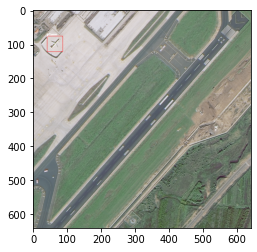

In [39]:
import random
random.seed(8500)
annotations = [os.path.join("Train\\labels", x) for x in os.listdir("Train\\labels") if x[-1:] == "t"]

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[0,2]] = annotations[:,[0,2]] * w
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * h
    
    transformed_annotations[:,0] = transformed_annotations[:,0] - (transformed_annotations[:,2] / 2)
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,0] + transformed_annotations[:,2]
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    
    for ann in transformed_annotations:
        x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline=255)
        
        plotted_image.text((x0, y0 - 10), 'plane')
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("labels", "imset").replace("txt", "png")
assert os.path.exists(image_file)
print(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)